# Linear Regression Model of Wind Farm Output
This notebook contains a model to predict wind farm contributions to electrical supply from time series windspeed data.



### Imports

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

### Read in Windspeed Data

In [46]:
wsp1 = pd.read_csv('../datasets/time_series/wsp_output1.csv')
wsp2 = pd.read_csv('../datasets/time_series/wsp_output2.csv')
wsp = pd.concat([wsp1,wsp2],axis=0)
wsp['date'] = pd.to_datetime(wsp['date'],format='%Y-%m-%dT%H:%M:%S')
wsp.set_index('date',inplace=True)
wsp.index = pd.to_datetime(wsp.index)
wsp['total'] = wsp.sum(axis=1)
print(wsp.shape)
wsp.tail(3)

(1632, 8)


,0,1,2,3,4,5,6,total
date,,,,,,,,
2020-05-21 21:00:00,28209.12,13261.28,8942.05,2432.0,2683.8,506.0,4026.96,60061.21
2020-05-21 22:00:00,28209.12,14918.94,9629.90,2736.0,2385.6,404.8,4474.40,62758.76
2020-05-21 23:00:00,35261.40,14918.94,9629.90,3344.0,2683.8,303.6,4474.40,70616.04


### Read in Wind Farm Output Data

In [47]:
ts = pd.read_csv('../datasets/time_series/renewables_series.csv')
ts['date'] = pd.to_datetime(ts['date'])
ts.set_index('date', inplace=True)
mwh = ts.resample('H').mean()
print(mwh.shape)
mwh.tail(3)

(18504, 5)


,solar,wind,geothermal,biomass,biogas
date,,,,,
2020-05-21 21:00:00,-3.000000,3037.583333,938.250000,347.833333,230.666667
2020-05-21 22:00:00,-3.000000,3265.083333,941.583333,341.833333,229.666667
2020-05-21 23:00:00,-3.909091,3296.090909,941.818182,338.090909,230.000000


### Merge datasets on time index

In [48]:
data = pd.merge(wsp,mwh['wind'],how='left',left_index=True, right_index=True)
print(data.shape)
data.head(3)

(1632, 9)


,0,1,2,3,4,5,6,total,wind
date,,,,,,,,,
2020-03-15 00:00:00,28209.12,11603.62,7566.35,4256.0,2087.4,506.0,6264.16,60492.65,1728.250000
2020-03-15 01:00:00,28209.12,11603.62,9629.90,4256.0,2087.4,303.6,6711.60,62801.24,1464.333333
2020-03-15 02:00:00,24682.98,11603.62,8942.05,4256.0,1789.2,303.6,6711.60,58289.05,1282.166667


### EDA

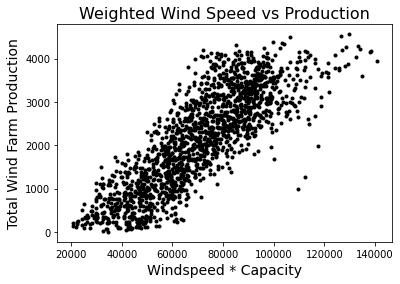

In [49]:
plt.plot(data['total'],data['wind'],'k.')
plt.xlabel('Windspeed * Capacity',fontsize=14)
plt.ylabel('Total Wind Farm Production',fontsize=14)
plt.title('Weighted Wind Speed vs Production',fontsize=16);
# plt.savefig('../images/weighted-wsp_vs_production.png',dpi=235,bbox_inches='tight');

In [50]:
data.corr()['wind']

0        0.764433
1        0.532667
2        0.584200
3        0.130339
4        0.004579
5        0.067349
6        0.372873
total    0.829665
wind     1.000000
Name: wind, dtype: float64

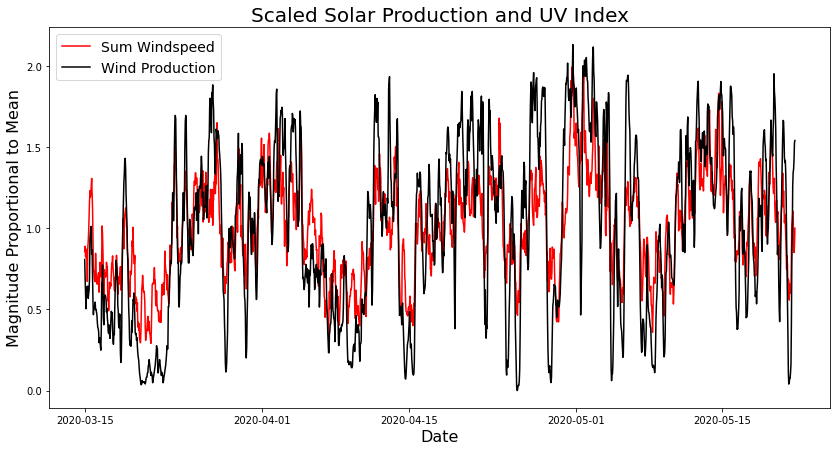

In [51]:
plt.figure(figsize=(14,7))
plt.plot(wsp.index,wsp.sum(axis=1)/np.mean(wsp.sum(axis=1)),'r-',label='Sum Windspeed')
plt.plot(wsp.index,data['wind']/np.mean(data['wind']),'k-',label='Wind Production')
plt.ylabel('Magnitude Proportional to Mean',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.title('Scaled Solar Production and UV Index',fontsize=20)
plt.legend(loc='upper left',fontsize=14);

### Train test split

In [52]:
X = data.drop(columns='wind')
y = data['wind']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,shuffle=False)

### Fit model and generate predictions

In [53]:
lr = LinearRegression()
lr.fit(X_train,y_train)
preds = lr.predict(X_test)

### Visualize results

RMSE = 523.4
Training score: 0.756
Testing score: 0.704


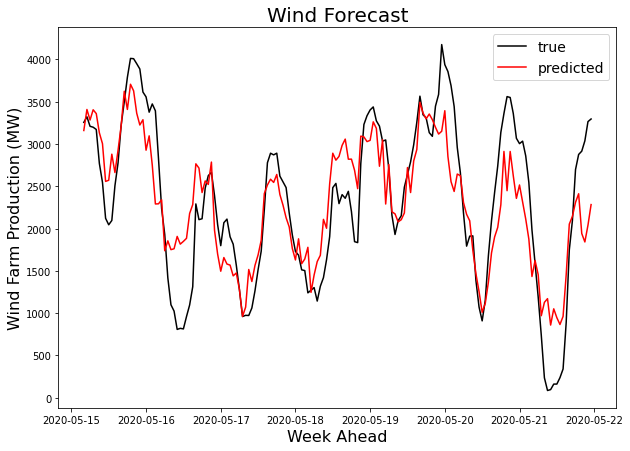

In [65]:
print(f"RMSE = {round(np.sqrt(mean_squared_error(y_test, preds)),1)}")
print(f"Training score: {round(lr.score(X_train,y_train),3)}")
print(f"Testing score: {round(lr.score(X_test,y_test),3)}")
plt.figure(figsize=(10,7))
plt.plot(y_test.index,y_test,'k-',label='true')
plt.plot(y_test.index,preds,'r-',label='predicted')
plt.legend(fontsize=14)
plt.xlabel('Week Ahead',fontsize=16)
plt.ylabel('Wind Farm Production (MW)',fontsize=16)
plt.title('Wind Forecast',fontsize=20);
plt.savefig('../images/wind_forecast.png',dpi=235,bbox_inches='tight');

### Write predictions to file

In [55]:
predictions = pd.DataFrame({'date':y_test.index,'wind_prediction':preds})
predictions.to_csv('../datasets/wind_prediction.csv',index=False)